In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
## Local Directory
file_dir = "/Users/andreacosta/Desktop/Projects/AircraftEngines/data/"

### Load Data:

In [3]:
# load training data prepared previously
df_train = pd.read_csv(file_dir+'train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [4]:
# load test data prepared previously
df_test = pd.read_csv(file_dir+'test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


### Regression Modelling:

Segment training and test data into features dataframe and labels series.  

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframes

In [5]:
#Prepare data for regression model

# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# a variable to hold the set of features to experiment with
features = features_orig


X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

Create a helper function to calculate regression metrics

In [6]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

Create a helper function to plot the coefficients weights or feature importance

In [7]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None
    

Create a helper function to plot the regression residuals

In [8]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()
    
    

Using the above functions let us model and evaluate some regression algorithms

### Linear Regression

In [9]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.405


,Linear Regression
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


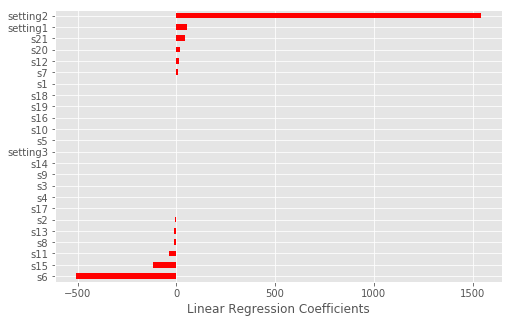

In [10]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

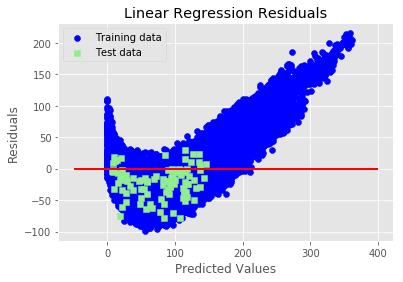

In [11]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

### LASSO

In [12]:
lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.579, R^2 test: 0.408


,LASSO
Root Mean Squared Error,31.966099
Mean Absolute Error,25.551808
R^2,0.408275
Explained Variance,0.668206


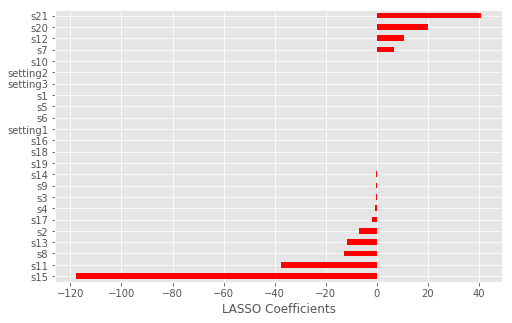

In [13]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

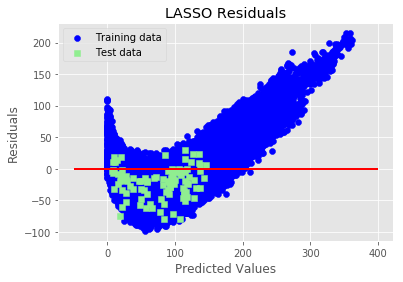

In [14]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

In [15]:
rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.580, R^2 test: 0.408


,Ridge Regression
Root Mean Squared Error,31.965740
Mean Absolute Error,25.544620
R^2,0.408289
Explained Variance,0.667607


### Ridge Regression

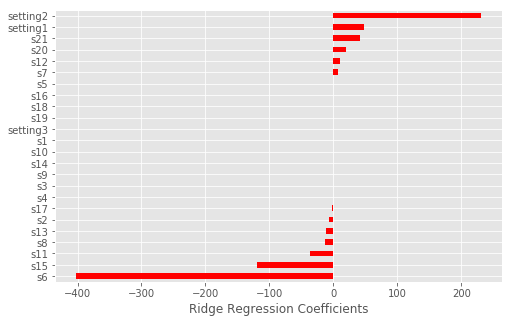

In [16]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

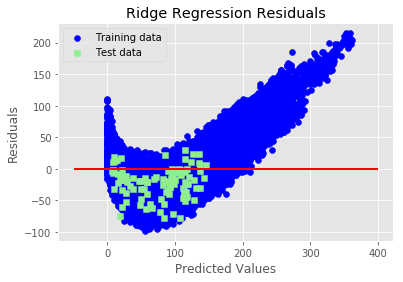

In [17]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

### Polynomila Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.437


,Polynomial Regression
Root Mean Squared Error,31.172286
Mean Absolute Error,23.761250
R^2,0.437299
Explained Variance,0.642814


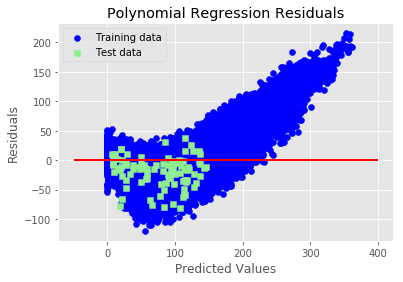

In [19]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

Polynomial Regression has scored better than linear models.

**Knowledge of the engine functioning may enable to craft more suited features and further enhance the performance.**

### Decision Tree regressor

In [27]:
dtrg = DecisionTreeRegressor(max_depth=9, max_features=10, random_state=123) # selected features
#dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.654, R^2 test: 0.421


,Decision Tree Regression
Root Mean Squared Error,31.617478
Mean Absolute Error,23.798766
R^2,0.421112
Explained Variance,0.607399


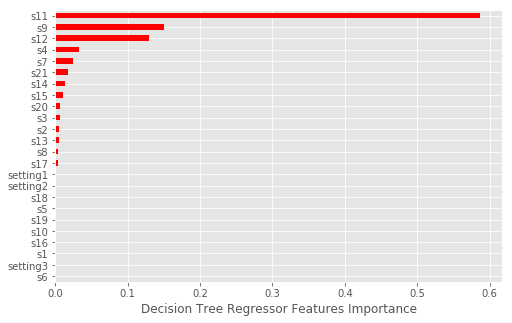

In [28]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 't' )

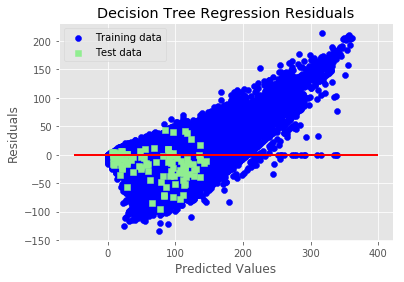

In [29]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)

Let us try some feature selection on decsion tree, for example Recursive Feature Elimination (RFE)

Optimal number of features : 4
The selected features are: ['s4', 's9', 's11', 's12']


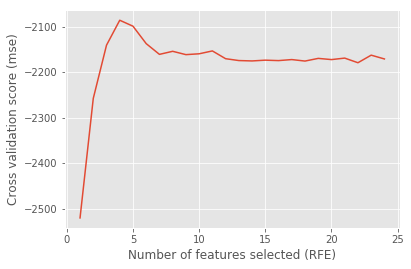

In [30]:
# recursive feature elimination
kfold = model_selection.KFold(n_splits=5, random_state=10)

dtrg = DecisionTreeRegressor(max_depth=9)

rfecv = RFECV(estimator=dtrg, step=1, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

sel_features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are: {}'.format(sel_features))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected (RFE)")
plt.ylabel("Cross validation score (mse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Test the same model with the selected features

In [32]:
# Decition Tree with selected features

#trnsform train and test data
X_train_trn = rfecv.transform(X_train)
X_test_trn = rfecv.transform(X_test)

print(X_train.shape)

dtrg = DecisionTreeRegressor(max_depth=7)

dtrg.fit(X_train_trn, y_train)

y_test_predict = dtrg.predict(X_test_trn)

dtrg_fs_metrics = get_regression_metrics('Decision Tree: Selected Features', y_test, y_test_predict)

#combine decision tree results: All features and selected features
dtr_metrics = pd.concat([dtrg_fs_metrics,dtrg_metrics], axis=1)

dtr_metrics

(20631, 24)


,Decision Tree: Selected Features,Decision Tree Regression
Root Mean Squared Error,33.496543,31.617478
Mean Absolute Error,25.360589,23.798766
R^2,0.350259,0.421112
Explained Variance,0.598800,0.607399


Model performance using only 5 top important features is comparable to using all 24 features.  

What is % importance of these 5 features?

In [33]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(sel_features, dtrg.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

importances.sort_values(by='Importance', ascending=False)

,Importance
s11,0.693419
s9,0.170615
s4,0.094024
s12,0.041942


### Random Forest

In [40]:
# #Nota Bene: this cell will take ~160mins of computing time

# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(X_train, y_train)

# print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  14.5s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  14.7s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  50.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.6min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  50.2s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.1min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.2min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total= 5.2min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimator

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=  41.2s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total= 1.5min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total= 1.3min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total= 1.4min
[CV] n_estimators=1

[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total= 7.3min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  56.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total= 7.8min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  55.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=

[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=  48.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  38.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  39.0s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, min_samples_spl

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 79.6min


[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 3.9min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 3.8min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total= 8.0min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 3.9min
[CV] n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total= 3.7min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  47.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  48.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  49.7s
[CV] n_estimator

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total= 1.9min
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=  19.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=  21.0s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=  26.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=  26.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=  13.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=  13.0s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=  27.3s
[CV] n_estimators=1600, mi

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total= 2.4min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=  39.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=  41.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total= 2.4min
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 156.5min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [46]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_test, y_test)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)


print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 6.4040 degrees.
Accuracy = 87.73%.
Model Performance
Average Error: 22.5136 degrees.
Accuracy = 62.24%.
Improvement of -29.06%.


In [48]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,\
           max_features='sqrt', max_leaf_nodes=None,\
           min_impurity_decrease=0.0, min_impurity_split=None,\
           min_samples_leaf=4, min_samples_split=2,\
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,\
           oob_score=False, random_state=None, verbose=0, warm_start=False)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.697, R^2 test: 0.471


,Random Forest Regression
Root Mean Squared Error,30.236591
Mean Absolute Error,22.218831
R^2,0.470573
Explained Variance,0.675872


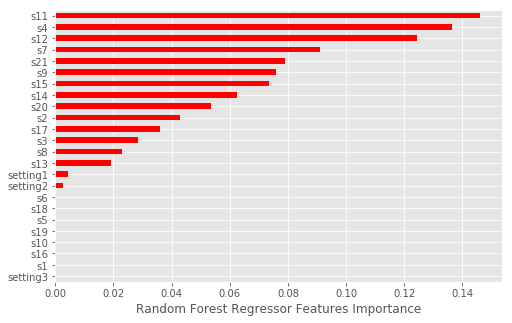

In [49]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

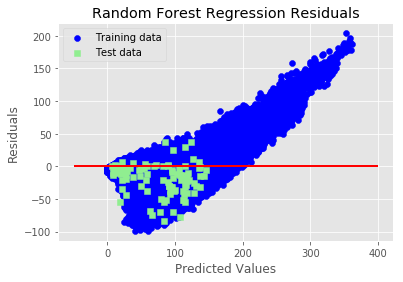

In [50]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

In [51]:
# view predictions vs actual
rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Actual,112.000000,98.000000,69.000000,82.00000,91.000000,93.000000,91.000000,95.000000,111.000000,96.000000,...,38.000000,20.000000,85.000000,55.000000,128.000000,137.000000,82.000000,59.000000,117.000000,20.000000
Prediction,164.124802,136.126762,68.913155,102.45304,121.298991,131.407505,121.204715,100.447785,124.781067,127.693486,...,33.455344,23.206167,47.319379,51.638379,154.307291,168.571341,80.975165,97.159558,157.894376,19.687575


#### Compare all regression models tested

In [52]:
#regression metrics comparison before feature engineering
reg_metrics_bfe = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_bfe

,Linear Regression,LASSO,Ridge Regression,Decision Tree Regression,Polynomial Regression,Random Forest Regression
Root Mean Squared Error,32.041095,31.966099,31.965740,31.617478,31.172286,30.236591
Mean Absolute Error,25.591780,25.551808,25.544620,23.798766,23.761250,22.218831
R^2,0.405495,0.408275,0.408289,0.421112,0.437299,0.470573
Explained Variance,0.665297,0.668206,0.667607,0.607399,0.642814,0.675872


__Regression Summary:__  

In accordance with our analysis in the data exploratory phase, non-linear regression models like Polynomial and Random Forest performed better than linear models like OLS, LASSO and Ridge regression. Random Forest clearly outperformed other models scoring RMSE of 28.63 cycles, i.e. the model predicts TTF within average error range of ±28.63 cycles.

The hyper-parameter tuning for the Random Forest Regressor, LASSO, and Ridge models was done manually, but Grid Search or Random Search with Cross Validation could be used for better processing.

